IMPORTING LIBRARIES

In [2]:

import keras
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,Flatten,UpSampling2D,Reshape, GlobalAveragePooling2D,Dense,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
%matplotlib inline
!pip3 install -U segmentation-models

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install augmentor
import Augmentor

In [3]:
import os
import logging



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AUGMENTATION OF IMAGES

In [5]:
class_1='fake'
root="/content/drive/MyDrive/Colab Notebooks/Real and Fake Face Prediction"
class_2='real'

In [ ]:
# Passing the path of the image directory
path=os.path.join(root,class_1)

p = Augmentor.Pipeline(source_directory=path,
                      output_directory="/content/drive/MyDrive/Colab Notebooks/Staircase Dataset/Augmented pics_fake")

# Defining augmentation parameters and generating 10 samples
p.flip_left_right(probability=0.4)
#p.flip_top_bottom(probability=0.8)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=10)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.sample(500)

In [ ]:
# Passing the path of the image directory
path=os.path.join(root,class_2)

p = Augmentor.Pipeline(source_directory=path,
                      output_directory="/content/drive/MyDrive/Colab Notebooks/Staircase Dataset/Augmented pics_real")

# Defining augmentation parameters and generating 10 samples
p.flip_left_right(probability=0.4)
#p.flip_top_bottom(probability=0.8)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=10)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.sample(500)

READING IMAGES AND CREATING DATASET

In [6]:
import random
def load_data(dir,uniqueLabels, size):
    img_array = []
    labels = []
    for category in uniqueLabels:
      path=os.path.join(dir,uniqueLabels)
      for img in random.sample(os.listdir(path),500):
          image=cv2.imread(os.path.join(path,img))
          resized_arr =  cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
          resized_arr =  cv2.resize(resized_arr,(size,size))
          img_array.append(resized_arr)
          labels.append(uniqueLabels)
    img_array = np.array(img_array)
    len(img_array)
    labels = np.array(labels)
    return(img_array, labels)

    #size = 32,32

In [7]:

Fake_Images,Fake_label=load_data(root,class_1,100)
Real_Images,Real_label=load_data(root,class_2,100)

In [ ]:
Real_Images[9].shape

(100, 100, 3)

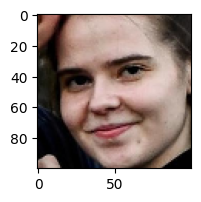

In [8]:
plt.figure(figsize=(2, 2))

plt.imshow(Real_Images[90])

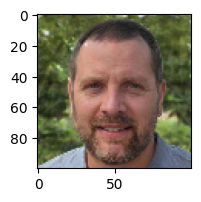

In [9]:
plt.figure(figsize=(2, 2))
plt.imshow(Fake_Images[10])


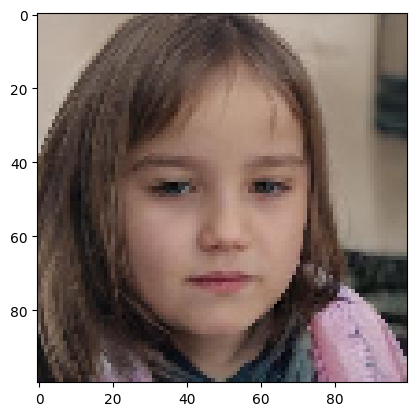

In [10]:
raw_x =[]

for feature in Fake_Images:

     plt.imshow(feature)
     raw_x.append(feature)
for feature in Real_Images:
     raw_x.append(feature)




In [ ]:
raw_x=np.array(raw_x)
raw_x.ndim

4

In [ ]:
raw_x.shape

In [11]:
raw_y=[]
for label in Fake_label:
  raw_y.append(label)
for label in Real_label:
  raw_y.append(label)

In [12]:
Face_Images=np.array(raw_x)
Face_label=np.array(raw_y)
Face_Images


array([[[[ 50,  52,  67],
         [ 55,  58,  77],
         [ 55,  62,  80],
         ...,
         [ 70,  89,  83],
         [ 74,  94,  82],
         [ 79, 100,  81]],

        [[ 51,  54,  69],
         [ 55,  61,  77],
         [ 57,  64,  80],
         ...,
         [ 68,  87,  81],
         [ 70,  90,  78],
         [ 76,  97,  78]],

        [[ 52,  56,  68],
         [ 56,  63,  79],
         [ 57,  67,  79],
         ...,
         [ 69,  90,  83],
         [ 71,  93,  81],
         [ 75,  98,  82]],

        ...,

        [[251, 221, 213],
         [238, 227, 182],
         [218, 228, 142],
         ...,
         [161, 164, 145],
         [ 70,  45,  74],
         [ 81,  43,  84]],

        [[243, 184, 204],
         [250, 215, 195],
         [241, 236, 170],
         ...,
         [156, 177, 121],
         [ 66,  61,  57],
         [105,  75, 109]],

        [[236, 166, 194],
         [251, 211, 201],
         [249, 242, 187],
         ...,
         [143, 178,  98],
        

In [13]:
print(Face_Images.ndim)
print(Face_Images.shape)
print(Face_label.ndim)
print(Face_label.shape)

4
(4000, 100, 100, 3)
1
(4000,)


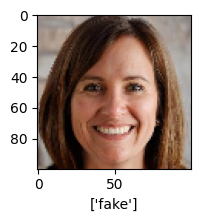

In [14]:

def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(Face_Images,Face_label,850)

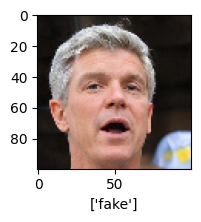

In [15]:
def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(Face_Images,Face_label,4)

TRAIN TEST SPLIT

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split (Face_Images,Face_label,train_size=0.7,random_state=64,shuffle=True)

In [17]:
print("Shape of x_train:{}".format(x_train.shape))
print("Shape of y_train:{}".format(y_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train:(2800, 100, 100, 3)
Shape of y_train:(2800,)
Shape of x_test: (1200, 100, 100, 3)
Shape of y_test: (1200,)


NORMALIZATION OF PIXELS

In [18]:
#variable assigne
X_train = x_train/255
X_test  = x_test/255
Y_train = y_train
Y_test  = y_test

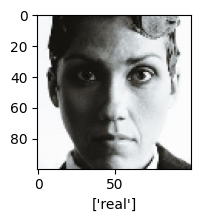

In [19]:
def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(X_train, Y_train,11)

LABEL ENCODING

In [20]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Encode y label/ dependent column
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)

for i in range(0,2):
    print("Class Label: {0}, --> Stair_type: {1}".format(i,le.inverse_transform([i])))

Class Label: 0, --> Stair_type: ['fake']
Class Label: 1, --> Stair_type: ['real']


VGG16 MODEL CREATION

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, BatchNormalization, Flatten

mnet = MobileNet(include_top = False, weights = "imagenet" ,input_shape=(100,100,3))
model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(64, activation = "ReLU"),
                    BatchNormalization(),
                    Dropout(0.01),
                    Dense(32, activation = "ReLU"),
                    #Dropout(0.01),

                    #Dense(4, activation = "ReLU"),
                    #Dropout(0.01),
                    Dense(1, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="binary_crossentropy", optimizer='adam', metrics="acc")

model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0 

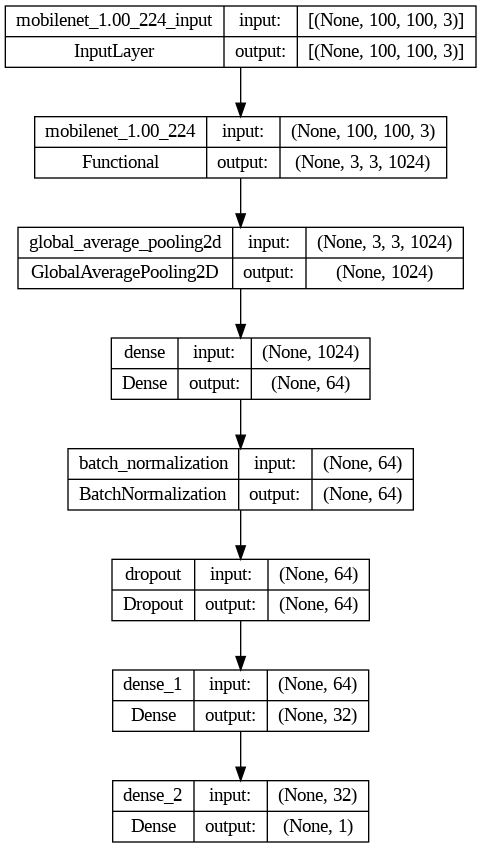

In [24]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Staircase Dataset/check_points-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, verbose=1, save_weights_only=True,
   # Save weights, every epoch.
   save_freq='epoch')

In [22]:
print(X_test.shape)
print(Y_test.shape)

(1200, 100, 100, 3)
(1200,)


MODEL TRAINING

In [23]:
interation=50
 #20,50
history = model.fit(X_train,Y_train,batch_size=6, epochs =interation, validation_data =(X_test, Y_test),verbose=1)#16,

Epoch 1/50
467/467 [==============================] - 52s 105ms/step - loss: 0.1536 - acc: 0.9436 - val_loss: 0.0221 - val_acc: 0.9958
Epoch 2/50
467/467 [==============================] - 48s 104ms/step - loss: 0.0800 - acc: 0.9757 - val_loss: 0.0209 - val_acc: 0.9975
Epoch 3/50
467/467 [==============================] - 46s 98ms/step - loss: 0.0607 - acc: 0.9811 - val_loss: 0.0182 - val_acc: 0.9992
Epoch 4/50
467/467 [==============================] - 37s 80ms/step - loss: 0.0592 - acc: 0.9811 - val_loss: 0.0134 - val_acc: 0.9983
Epoch 5/50
467/467 [==============================] - 48s 103ms/step - loss: 0.0528 - acc: 0.9821 - val_loss: 0.0158 - val_acc: 0.9983
Epoch 6/50
467/467 [==============================] - 38s 81ms/step - loss: 0.0475 - acc: 0.9832 - val_loss: 0.0100 - val_acc: 0.9992
Epoch 7/50
467/467 [==============================] - 49s 104ms/step - loss: 0.0426 - acc: 0.9857 - val_loss: 0.0126 - val_acc: 0.9983
Epoch 8/50
467/467 [==============================] - 37s 

In [ ]:
# Save the model as a SavedModel
model.save("my_model_mn_cnn.hdf5")

In [ ]:
# save in the H5 format
model.save("/content/drive/MyDrive/Colab Notebooks/Staircase Dataset/my_model_mn_cnn.hdf5")

In [ ]:
from keras.models import load_model

# load model
model = load_model('my_model_mn_cnn.hdf5')

In [26]:
test_score=model.evaluate(X_test,Y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

38/38 [==============================] - 12s 305ms/step - loss: 0.0143 - acc: 0.9983
Test loss: 0.014315645210444927
Test accuracy: 0.9983333349227905


In [27]:
train_score=model.evaluate(X_train,Y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

88/88 [==============================] - 28s 317ms/step - loss: 1.1359e-05 - acc: 1.0000
Train loss: 1.1359300515323412e-05
Train accuracy: 1.0


MODEL TESTING AND RESULT

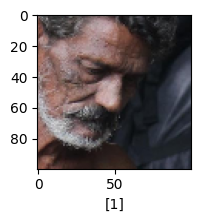

In [28]:
def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(X_test, Y_test,200)

In [29]:
image=X_test[200]

In [30]:
image.shape

(100, 100, 3)

In [31]:
img = image.reshape(1,100,100,3)

In [ ]:
img.shape

1/1 [==============================] - 1s 524ms/step
[[0.99999875]]
The Face is : Real


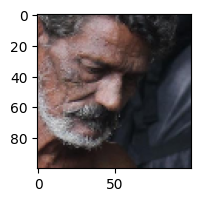

In [32]:
# make a prediction
ynew = model.predict(img)
print(ynew)

def plot_sample(X, y):

    plt.figure(figsize=(2, 2))
    plt.imshow(X[0])

plot_sample(img,ynew)

if(ynew>0.5):
  print("The Face is : Real")
if(ynew<0.5):
  print("The Face is: Fake")

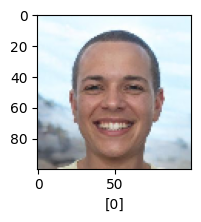

In [33]:
def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(X_test, Y_test,150)

In [34]:
image=X_test[150]
img = image.reshape(1,100,100,3)

1/1 [==============================] - 0s 40ms/step
[[1.3895378e-06]]
The Face is: Fake


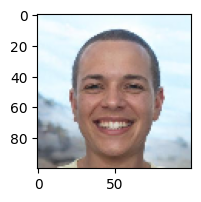

In [35]:
# make a prediction
ynew = model.predict(img)
print(ynew)

def plot_sample(X, y):

    plt.figure(figsize=(2, 2))
    plt.imshow(X[0])

plot_sample(img,ynew)

if(ynew>0.5):
  print("The Face is : Real")
if(ynew<0.5):
  print("The Face is: Fake")

In [36]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import metrics

In [38]:
X_test.shape

(1200, 100, 100, 3)

In [39]:
y_pred_array=[]
for i in range (0,1200):
  image=X_test[i]
  img=image.reshape(1,100,100,3)
  ynew = model.predict(img)
  if(ynew>0.5):
    y_pred_array.append(1)
  if(ynew<0.5):
    y_pred_array.append(0)

1/1 [==============================] - 0s 64ms/step


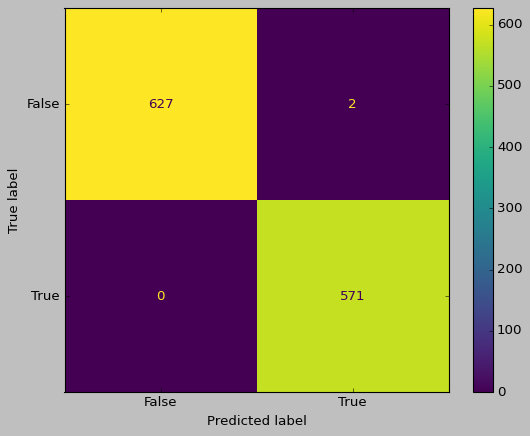

In [41]:
confusion_matrix = metrics.confusion_matrix(Y_test, y_pred_array)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [42]:

target_names = ['fake', 'real']
print(classification_report(Y_test,y_pred_array, target_names=target_names))

              precision    recall  f1-score   support

        fake       1.00      1.00      1.00       629
        real       1.00      1.00      1.00       571

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters for plotting
plt.rc('figure', figsize=(8, 4))
sns.set(font_scale=1)

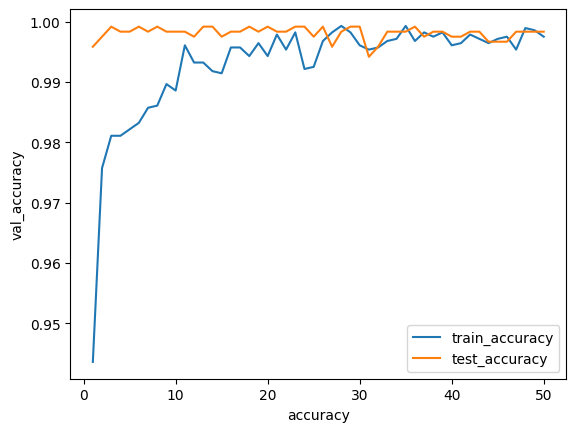

In [37]:
epochs=50
train_acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train_accuracy')
plt.plot(epochs_list, val_acc, label='test_accuracy')
plt.title("")
plt.xlabel('accuracy')
plt.ylabel('val_accuracy')
plt.legend(loc='best')

In [ ]:
for key in model.history.history.keys():
    print(key)

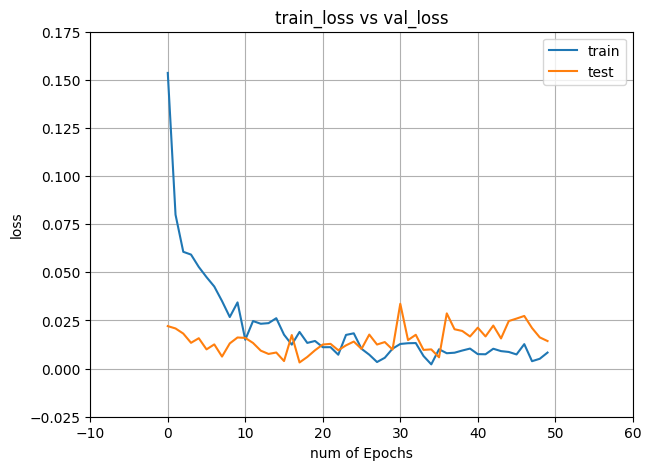

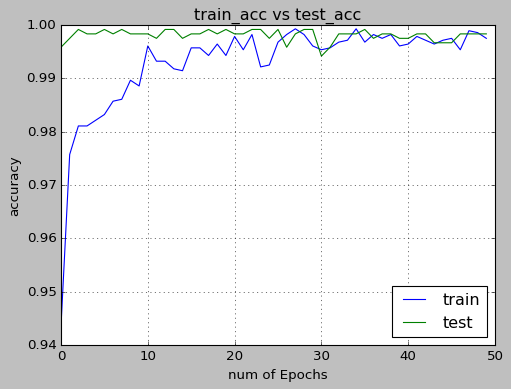

In [40]:
#Code by 'Real vs Fake face detection' https://www.kaggle.com/code/debasisdotcom/real-vs-fake-face-detection

epochs = 50
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_acc = history.history['acc']
test_acc = history.history['val_acc']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,test_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','test'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,test_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs test_acc')
plt.grid(True)
plt.legend(['train','test'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])